# Crossfit Subreddit Topic Modeling

1. Load Data / Cleaning
2. Vectorizer / Topic Model
3. Document Samples
4. Examine Documents / Words

In [1]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [2]:
import reddit as red
%load_ext autoreload
%autoreload 2

## 1. Load Data / Cleaning / Pre-processing
Data cleaning:
- Turn UTC time into datetime object
- Merge subreddit post title and body into single text document
- Remove 'deleted' or 'removed' posts
- Assign media designation for post (video or image)
- Remove duplicates

Data Pre-processing:
- Remove punctuation, numbers, links, slashes, emojis
- Convert to lower case
- Lemmatization using Spacy

In [7]:
#import data
picklefile_name = './reddit_pkl_data/2008_2021feb19_df.pkl'
with open(picklefile_name, 'rb') as picklefile: 
    df_orig = pickle.load(picklefile)

In [4]:
#clean data
df_praw = df_orig.copy()
df_praw = red.clean_praw_input(df_praw)
df_praw = red.clean_submissions(df_praw)
df_praw.drop(columns=['created', 'content_categories', 'is_meta'], inplace=True)

# Text preprocessing steps - remove numbers, captial letters, punctuation, new line characters
red.text_processing(df_praw)

#de-dup again
red.de_dup(df_praw)

df_praw.shape

(65792, 9)

In [ ]:
#lemmatization - NLTK
#lemm_arr = df_praw.full_text.map(red.lemmatize_sentence)

In [ ]:
#lemmatization - Spacy
lemm_arr = df_praw.full_text.map(red.lemmatize_spacy)

In [ ]:
corpus = lemm_arr

In [8]:
len(corpus)

65792

## 2. Vectorizer / Topic Model
- TFIDF Vectorizer
- NMF model

In [9]:
# add custom stop words
from sklearn.feature_extraction import text 

addl_stop_words = ['im', 'ive','just', 'nt', 've', 'like', 'want', 'year', 'good', 'really', 'think', 'know', 'try', 'work', 'new', 'today', 'week', 'thing', 'cf', 'time', 'thank', 'rx', 'start', 'help', 'home']

stop_words = text.ENGLISH_STOP_WORDS.union(addl_stop_words)

In [10]:
#countvectorizer
countV = CountVectorizer(stop_words=stop_words)
coo_countv = countV.fit_transform(corpus)

In [11]:
#TF-IDF Vectorizer
tfidfV = TfidfVectorizer(stop_words=stop_words)
coo_tfidf = tfidfV.fit_transform(corpus)

In [46]:
coo_tfidf.shape

(65792, 44130)

In [10]:
#NMF model
nmf_model = NMF(9)
doc_topic = nmf_model.fit_transform(coo_tfidf)

words = tfidfV.get_feature_names()
t = nmf_model.components_.argsort(axis=1)[:,-1:-10:-1]
topic_words = [[words[e] for e in l] for l in t]

for w_list in topic_words:
    print(w_list) 

['day', 'feel', 'weight', 'muscle', 'month', 'strength', 'body', 'make', 'training']
['crossfit', 'month', 'love', 'fitness', 'training', 'people', 'join', 'community', 'sport']
['squat', 'clean', 'snatch', 'pr', 'bar', 'jerk', 'power', 'deadlift', 'overhead']
['game', 'event', 'athlete', 'regional', 'watch', 'team', 'competition', 'individual', 'ticket']
['shoe', 'metcon', 'nano', 'reebok', 'nike', 'pair', 'look', 'size', 'wear']
['workout', 'daily', 'thread', 'question', 'journal', 'free', 'yesterday', 'simple', 'newbie']
['wod', 'run', 'round', 'burpee', 'hero', 'app', 'minute', 'strength', 'finish']
['open', 'video', 'score', 'movement', 'regional', 'scale', 'tip', 'sign', 'leaderboard']
['gym', 'box', 'look', 'coach', 'jump', 'class', 'area', 'owner', 'people']


In [11]:
# assign document to topic with max distribution
doc_cluster = doc_topic.argmax(axis = 1)

In [12]:
# see distritbution over topics
pd.Series(doc_cluster).value_counts()

0    16013
8    10372
1     9403
3     7220
2     6782
6     4580
4     4496
5     3964
7     2962
dtype: int64

In [13]:
# add topic back to dataframe
df_praw['topic'] = doc_cluster
df_praw.shape

(65792, 10)

In [14]:
# doc to topic distribution
doc_topic.shape

(65792, 9)

0 Crossfit Feels: ```['day', 'feel', 'weight', 'muscle', 'month', 'strength', 'body', 'make', 'training']```

1 Why I love Crossfit: ```['crossfit', 'month', 'love', 'fitness', 'training', 'people', 'join', 'community', 'sport']```

2 Personal Records: ```['squat', 'clean', 'snatch', 'pr', 'bar', 'jerk', 'power', 'deadlift', 'overhead']```

3 Crossfit Games: ```['game', 'event', 'athlete', 'regional', 'watch', 'team', 'competition', 'individual', 'ticket']```

4 Shoes: ```['shoe', 'metcon', 'nano', 'reebok', 'nike', 'pair', 'look', 'size', 'wear']```

5 Workouts: ```['workout', 'daily', 'thread', 'question', 'journal', 'free', 'yesterday', 'simple', 'newbie']```

6 WODs: ```['wod', 'run', 'round', 'burpee', 'hero', 'app', 'minute', 'strength', 'finish']```

7 Crosfit Open: ```['open', 'video', 'score', 'movement', 'regional', 'scale', 'tip', 'sign', 'leaderboard']```

8 Gym Adivce: ```['gym', 'box', 'look', 'coach', 'jump', 'class', 'area', 'owner', 'people']```

In [45]:
# topics to words matrix
nmf_model.components_.shape

(9, 44130)

In [ ]:
#pickle dataframe
pickle.dump(df_praw, open('df_praw_9topics.pkl', 'wb'))

Check number of topics

In [ ]:
from sklearn.utils.extmath import randomized_svd
U, Sigma, VT = randomized_svd(coo_tfidf, n_components=15,
                                      n_iter=5,
                                      random_state=None)

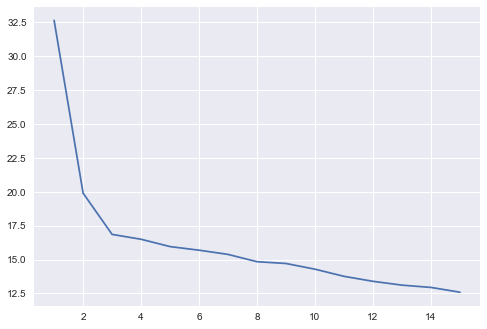

In [472]:
#TF-IDF
plt.plot(range(1,16),Sigma)
plt.show()

## 3. Document Samples

In [21]:
# view first few doc distributions across topics
df_doc_topic = pd.DataFrame(doc_topic)
df_doc_topic.head()

,0,1,2,3,4,5,6,7,8
0,0.000000,0.063613,0.006453,0.006957,0.000587,0.001146,0.005210,0.014104,0.00000
1,0.009036,0.003214,0.000000,0.000433,0.001511,0.000055,0.000000,0.000215,0.00000
2,0.005381,0.000000,0.001915,0.000000,0.000000,0.000187,0.001221,0.000000,0.00000
3,0.003297,0.002854,0.000000,0.000694,0.000327,0.000791,0.000000,0.000000,0.00449
4,0.004708,0.001655,0.000000,0.000474,0.000000,0.001101,0.000521,0.000350,0.00075


In [28]:
# look at top documents in specific topic
topic = 4
top_doc_list = df_doc_topic.sort_values(by=topic, ascending=False).head(80).index.tolist()

df_top = df_praw.iloc[top_doc_list]

In [29]:
for i in range(20):
    print(df_top.iloc[i].id, df_top.iloc[i].url)
    print(df_top.iloc[i].full_text)

2wfhfl http://www.reddit.com/r/crossfit/comments/2wfhfl/enough_about_the_shoes/
enough about the shoes 
9fzpya https://i.redd.it/kzgjxgcavcm11.jpg
which shoe 
4u9x75 http://imgur.com/Q8eKMDm
what shoes are these 
6e7qn5 https://www.reddit.com/r/crossfit/comments/6e7qn5/best_crossfit_shoes/
best crossfit shoes hey all  im looking for a new pair of shoes ive never had weightlifting shoes and i was wondering if you all can make some recommendations on shoes good for crossfit and olympic lifts  is it as simple as getting a pair of the reebok nanos or nike metcons  sorry if this is a dumb question i appreciate any feedback
prm16 http://www.reddit.com/r/crossfit/comments/prm16/shoes/
shoes what shoes do you wear to workout
esl7ga https://www.reddit.com/r/crossfit/comments/esl7ga/crossfit_shoes_the_good_the_bad_are_they_worth_it/
crossfit shoes the good the bad are they worth it so i recently started crossfit about almost a month and a half ago and im loving it im still a big guy but im doing

In [40]:
# view original text for specific post ID
df_orig[df_orig.id == 'esl7ga'].selftext.values[0]

'So I recently started CrossFit about almost a month and a half ago and I’m loving it. I’m still a big guy but I’m doing the best I can and it’s been a game changer. I’ve been looking at CrossFit shoes.\n\nIf I’m correct, you need a CrossFit shoe because you need a shoe that’s more flat to the ground so you can have more balance and explosive lifts if I’m correct? \n\nI’ve been looking at different shoes and I went to the Reebok outlet and I picked out and got a pair of blue nano 9s Reebok. At first I really liked him and with three group classes with them they are good but I can tell that the back part of the shoe the heel, is really flexible and every time I take a step, I feel my back heel going up. Didn’t know if anyone else had this problem with the shoes. Are all CrossFit shoes like this? Is this OK or should I find another pair of shoes. Thank you so much'

Identify documents with no clear topic assignment

In [53]:
s = pd.DataFrame(doc_topic).sum(axis=1)
no_topic = s[s==0].index.tolist()
len(no_topic)

266

In [54]:
df_praw.iloc[no_topic].head()

,author,id,num_comments,score,url,upvote_ratio,time,full_text,media
954,zosboss,hxa49,3,14,http://i.imgur.com/KpVtXl.jpg,NaN,2011-06-11 19:39:42,see you there,image
809,[deleted],j2pt8,0,0,http://wodkillergear.com/components/com_virtue...,NaN,2011-07-29 01:16:55,like this,image
631,neanderdude,kdii2,26,8,http://i.minus.com/iIen5yHufoj4y.png,NaN,2011-09-12 22:45:08,anyone else,image
436,jrbowlder,lwn7h,10,12,http://www.youtube.com/watch?v=myw1NlGQMIQ&amp...,NaN,2011-11-01 18:48:10,over headscary,NaN
268,uber_coolio,n3vmn,0,0,http://qkme.me/35fnhf,NaN,2011-12-07 13:25:06,all the things,NaN


In [55]:
df_praw[~df_praw.index.isin(no_topic)]

,author,id,num_comments,score,url,upvote_ratio,time,full_text,media
168,wats8976,7lzfw,0,3,https://www.reddit.com/r/crossfit/comments/7lz...,NaN,2008-12-27 23:24:43,whats your favorite crossfit video,none
150,jerodhoffman,7ucsy,1,1,http://thefitnessrevelation.com/2008/08/22/fun...,NaN,2009-02-02 21:48:29,reasons functional training leads to better ...,NaN
148,[deleted],7ul3a,6,4,https://www.reddit.com/r/crossfit/comments/7ul...,NaN,2009-02-03 18:27:48,am i the only one who finds the pullup require...,none
147,jerodhoffman,7ulx9,0,0,http://thefitnessrevelation.com/2009/01/29/sav...,NaN,2009-02-03 19:53:06,save time and money homegrown fitness the fi...,NaN
146,jerodhoffman,7vvku,0,1,http://thefitnessrevelation.com/2009/02/08/ket...,NaN,2009-02-09 02:09:59,kettlebell trainingunlock mental toughness and...,NaN
...,...,...,...,...,...,...,...,...,...
62651,mayfinallypost,lmwoq7,0,1,https://i.redd.it/vcv72mifsai61.jpg,1.0,2021-02-18 20:42:47,who knew the secret to perfect double unders w...,image
62649,GoddessLissys,lmx3nh,4,1,https://i.redd.it/2kfi80wmvai61.jpg,1.0,2021-02-18 21:00:27,are you willing and ready to serve snapchat,image
62648,worthmotion,lmx3td,6,1,https://i.redd.it/m66t4e6ovai61.jpg,1.0,2021-02-18 21:00:38,couldnt leave this fan favorite out,image
62646,FITwithWS,lmywp7,0,1,https://youtu.be/cBt6zi3m1RU,1.0,2021-02-18 22:16:14,hello all in this video i show you how to do t...,NaN


## 4. Examine Documents / Words

Look at top words by count value using the count vectorizer

In [12]:
df_countV = pd.DataFrame(coo_countv.toarray(), columns=countV.get_feature_names())
df_countV.head()

,aa,aaa,aaaaaaaaaay,aaaaaaaabqm,aaaaaaaadjo,aaaaaaah,aaaaaahhhhhggggghhhhhhh,aaaaaalmost,aaaaaand,aaaaand,...,zururu,zuu,zuzka,zvejniek,zwift,zy,zyji,zyzz,zzacv,zzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# add row with sum of words
df_countV = df_countV.append(df_countV.sum(),ignore_index=True)

In [63]:
df_countV.shape

(65793, 44130)

In [64]:
df_countV.iloc[-1].sort_values(ascending=False).head(20)

crossfit    38965
workout     15022
gym         14183
box         13043
day         12777
wod         12111
look        11426
feel        10395
make         9481
use          9339
month        8301
weight       8267
squat        8080
people       7226
need         6837
guy          6810
game         6783
athlete      6033
run          6015
strength     5955
Name: 65792, dtype: int64

Find examples of documents with specific words using tfidf vectorizer

In [16]:
# create df with tfidf vectorizer matrix
df_tfidf = pd.DataFrame(coo_tfidf.toarray(), columns=tfidfV.get_feature_names())
df_tfidf.head()

,aa,aaa,aaaaaaaaaay,aaaaaaaabqm,aaaaaaaadjo,aaaaaaah,aaaaaahhhhhggggghhhhhhh,aaaaaalmost,aaaaaand,aaaaand,...,zururu,zuu,zuzka,zvejniek,zwift,zy,zyji,zyzz,zzacv,zzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# map topic to tfidf matrix df
df_tfidf['topic'] = doc_cluster

In [20]:
# search word in top 20 documents in topic
word = 'love'
topic = 1

list_samples = list(df_tfidf[word].sort_values(ascending=False).head(20).index)

mask = (df_tfidf[word] > 0) & (df_tfidf.topic == topic)
# look at random document
random_sample = random.choice(list(df_tfidf[mask][word].index))
print(random_sample)
print(df_praw.url.iloc[random_sample])
df_praw.full_text.iloc[random_sample]

32369
https://www.reddit.com/r/crossfit/comments/598chq/can_i_still_do_crossfit/


'can i still do crossfit hey guys  so a few years ago i decided to try crossfit i love calisthenics and i loved the intensity of the workouts but one day during the strength training i dislocated my shoulder doing snatch and ever since then it pops out really easily since then ive taken up regular free weight training which is working just fine but i like crossfit a lot more im just so hesitant to go back to it with my shoulder and im terrified of snatch now   i went and visited with a box here where i live now and the coach wanted me to take a   on   class they offered to work on my form but with how easily my shoulder pops out im really not wanting to do snatch at all since then i have had it pop out by just doing sit ups its crazy i should clarify though that the only bad dislocation ive had was with snatch a few years ago the other times it slipped back in and didnt hurt   so am i even able to do crossfit any input is appreciated '

In [21]:
for idx in list_samples:
    print(df_praw.full_text.iloc[idx])

i love this thing 
i think im in love 
love all of you 
i loved    
i love what i do 
i love it 
this is why i love crossfit 
i love you more than crossfit 
why i love going to my cf gym 
just started doing crossfit  i love doing these who else loves handstand pushups 
i love crossfit all you people keep on keeping on
this is what makes me love my box 
love our sport 
q how do you know if someone loves crossfit a theyve told you 
what the athletes at my box see me as im loving it 
this is why i love crossfit anyone can do the workout you just need to go 
i love this workout just wanted to put it up because i havent yet let me know what you think 
i love my job 
why i love paleo  
love it so much its amazing 


### Filtering:
- Documents pertaining to glassman issue
- Pandemic vs pre-Pandemic

In [22]:
df_praw.shape

(65792, 10)

In [24]:
df_tfidf.shape

(65792, 44130)

Fiter out documents containing "glassman", "castro", and "hq"

In [ ]:
df_praw['glassman'] = df_countV.glassman.iloc[:-1]
df_praw['castro'] = df_countV.castro.iloc[:-1]
df_praw['hq'] = df_countV.hq.iloc[:-1]

In [28]:
mask = (df_countV.glassman > 0) | (df_countV.castro > 0) | (df_countV.hq > 0)
df_countV[mask].shape

(1464, 44130)

In [ ]:
picklefile_name = 'df_praw_full_blm.pkl'
with open(picklefile_name, 'wb') as picklefile:
    pickle.dump(df_praw, picklefile)

Filter out pandemic and pre-pandemic documents

In [7]:
#fliter
mask = (df_praw['time'] >= pd.to_datetime('2019-03-01')) & (df_praw['time'] <= pd.to_datetime('2020-02-28'))
df_pre_pandemic = df_praw[mask]

In [ ]:
#fliter
mask = df_praw['time'] >= '2020-03-01'
df_pandemic = df_praw[mask]